# Mobilités professionnelles motorisées : statistiques nationales de l'INSEE

Document en cours de travail - Émilien - 28/07/2022

&#127919; **Objectif du notebook** : présenter un traitement de données de recensement de l'INSEE sur les mobilités professionnelles des français à partir des données "brutes" en montant les étapes pour réaliser une carte.

&#128218; **Données** : Données INSEE du recensement 2016 sur les mobilités professionnelles rendues disponibles en 2018 (N = 7 824 392) https://www.insee.fr/fr/statistiques/4171531?sommaire=4171558 complétées par d'autres données INSEE sur les communes.

&#10067; **Question de recherche**: comment caractériser à l'échelle nationale les pratiques de mobilités des français ? Comment se structure l'espace ?

<div class="alert alert-block alert-warning">
<b>Philosophie générale</b> 
     <br>

&#10148; Notebook construit selon un modèle narratif linéaire exécutable ; <br>
    
&#10148; Prioritée donné à la lisibilité en détaillant les étapes (forte verbosité ; une cellule par étape) ; <br>

&#10148; Application des bonnes pratiques de programmation en langage Python &#128013; (structure avec [Cookiecutter Data Science](https://drivendata.github.io/cookiecutter-data-science/#directory-structure) et [Black](https://black.readthedocs.io/en/stable/index.html) pour le code) ; <br>
   
&#10148; Séparation données/traitement (entre les données brutes et le code, et dans le code) ; <br>
        
&#10148; Recherche d'un équilibre entre minimisation du nombre de bibliothèques et facilité d'usage ; <br>
            
&#10148; Documentation du code respectant les standards ([numpydoc docstrings](https://numpydoc.readthedocs.io/en/latest/format.html) utilisé notamment par [scikit-learn](https://scikit-learn.org/stable/)); <br>
    
&#10148; Mention explicite des versions de bibliothèques utilisées ; <br>

</div>

## Contexte

### Données

Données ouvertes &#128275; disponibles sur le site de l'INSEE. Nous utiliserons plusieurs données différentes.

Données du recensement 2016 sur les mobilités professionnelles rendues disponibles en 2018 (N = 7 824 392) https://www.insee.fr/fr/statistiques/4171531?sommaire=4171558

- Données bilocalisées domicile-travail à la commune, décrivant les caractéristiques de l'individu, de son ménage et de sa résidence principale,
- variables de tri : commune de résidence / commune de travail (y compris commune de travail située dans les pays frontaliers),
- champ : individus actifs ayant un emploi et âgés de 15 ans ou plus.

Comme elles sont volumineuses, il est préférable de les télécharger en local pour les ouvrir, surtout si le Notebook doit être exécuté plusieurs fois.

Pour avoir des informations sur la commune à proprement parler, il est intéressant de compléter les données individuelles par des données à l'échelle des communes aussi disponibles grâce à l'INSEE : https://www.insee.fr/fr/statistiques/5359146

### Démarche  générale

1. Charger les données, les explorer et les transformer pour permettre les analyses

- un des enjeux est le travail avec des données assez volumineuses
- un exemple d'usage d'API pour faire du routage est proposé

2. Réaliser des cartes à partir des informations géographiques
3. Réduction de la dimensionnalité avec la classification pour faciliter les modèles

### Choix de bibliothèques

L'analyse de données de questionnaire en sciences sociales nécessite trois grands types d'outils :

1. La manipulation de données tabulaires, facilité par la bibliothèque `Pandas`
2. L'association aux données géographiques avec `GeoPandas` complété avec `Geopy` et `Pysal` pour les calculs
3. Les modèles de classification avec `Sklearn` et `Statsmodels`


**Chargement des bibliothèques**

Attention : en local, `Geopandas` peut dans certains cas être difficile à installer.

In [5]:
# Modules standards
import zipfile
import os
import pickle

# Requêtes HTTP
import wget
import requests

# Tableaux
import pandas as pd

# Visualisation
import matplotlib.pyplot as plt

# Géographie
import geopandas as gpd
from geopy.distance import geodesic

# Analyse de réseaux
import networkx as nx
import pyvis

# Statistiques
import numpy as np
import sklearn
from sklearn.cluster import KMeans
import pyshs
import prince

## 1. Chargement des données

- individuelles sur les déplacements
- informations sur les communes
- fond de carte géographique

Téléchargement en local uniquement si les données ne sont pas encore téléchargées

In [2]:
# Données à l'échelle des déplacements individuels de l'INSEE
if not os.path.exists("../data/RP2016_mobpro_csv.zip"):
    url='https://www.insee.fr/fr/statistiques/fichier/4171531/RP2016_mobpro_csv.zip'
    wget.download(url,"../data/RP2016_mobpro_csv.zip")
else:
    print("Les données individuelles sont déjà téléchargées")

# Données à l'échelle des communes de l'INSEE
if not os.path.exists("../data/RP2016_dossier_complet.zip"):
    url='https://www.insee.fr/fr/statistiques/fichier/5359146/dossier_complet.zip'
    wget.download(url,"../data/RP2016_dossier_complet.zip")
else:
    print("Les données des communes sont déjà téléchargées")
    
# Carte des communes de OSM
if not os.path.exists("../data/communes-20220101-shp.zip"):
    url = "https://osm13.openstreetmap.fr/~cquest/openfla/export/communes-20220101-shp.zip"
    wget.download(url,"../data/communes-20220101-shp.zip")
else:
    print("Le fond de carte est déjà téléchargé")

Les données individuelles sont déjà téléchargées
Les données des communes sont déjà téléchargées
Le fond de carte est déjà téléchargé


Ouverture des données qui sont des archives zip avec plusieurs fichiers dedans.

(attention, les fichiers sont lourds, l'opération peut prendre du temps en local)

In [6]:
# Chargement des données à l'échelle des individus
zip_file = zipfile.ZipFile('../data/RP2016_MOBPRO_csv.zip') #zip_file.infolist()
data_ind = pd.read_csv(zip_file.open("FD_MOBPRO_2016.csv"),sep=";",low_memory=False) #, nrows=1000000
meta_ind = pd.read_csv(zip_file.open("Varmod_MOBPRO_2016.csv"),sep=";")

# Chargement des données à l'échelle de la commune
zip_file = zipfile.ZipFile('../data/RP2016_dossier_complet.zip')
data_com = pd.read_csv(zip_file.open("dossier_complet.csv"),sep=";",low_memory=False) #, nrows=100)
meta_com = pd.read_csv(zip_file.open("meta_dossier_complet.csv"),sep=";")

# Chargement de la carte
carte = gpd.read_file("../data/communes-20220101-shp.zip")

Par la suite nous voulons associer les individus/communes/carte, pour cela il faut que le code commune soit identique sur les différents jeux de données. Après vérification, il faut s'assurer que chaque code est bien une chaine de caractère de 5 éléments, en ajoutant des 0 avant. Les clés d'association sont cruciales quand on travaille avec plusieurs tableaux.

In [7]:
data_com["CODGEO"] = data_com["CODGEO"].apply(lambda x : str(x).zfill(5))
data_ind["COMMUNE"] = data_ind["COMMUNE"].apply(lambda x : str(x).zfill(5))
data_ind["DCLT"] = data_ind["DCLT"].apply(lambda x : str(x).zfill(5))

Nous définissons aussi deux fonctions qui permettent de circuler plus facilement dans les métadonnées, ici donner le descriptif d'une variable et ses modalités.

In [20]:
def modalites(var,meta):
    """
    Renvoyer les modalités d'une variable
    """
    t = meta.set_index("COD_VAR").loc[var]
    return dict(t.set_index("COD_MOD")["LIB_MOD"])

def description(var,meta):
    """
    Renvoyer la decription d'une variable
    """
    t = meta.set_index("COD_VAR").loc[var]
    return t["LIB_VAR"].drop_duplicates().iloc[0]

Exemple d'utilisation

In [21]:
description("CS1",meta_ind)

'Catégorie socioprofessionnelle en 8 postes'

In [22]:
modalites("CS1",meta_ind)

{'1': 'Agriculteurs exploitants',
 '2': "Artisans, commerçants et chefs d'entreprise",
 '3': 'Cadres et professions intellectuelles supérieures',
 '4': 'Professions Intermédiaires',
 '5': 'Employés',
 '6': 'Ouvriers',
 '7': 'Retraités',
 '8': 'Autres personnes sans activité professionnelle'}

## 2. Statistiques sur les déplacements à l'échelle des déplacements individuels

Nous avons des données de statistiques assez grandes et variées. Elles permettent de faire de nombreux traitements. Dans cette première étape, nous nous intéressons au déplacement des individus à l'échelle individuelle.

### 2.1 Repérer et recoder les variables

Une première étape est d'identifier les variables et de recoder en fonction de nos besoins. D'autres variables pourraient être utilisées

- `IPONDI`	Poids de l'individu **pondération**

**variables dépendantes**

- `VOIT`	Nombre de voitures du ménage
- `TRANS`	Mode de transport principal le plus souvent utilisé pour aller travailler

**variables indépendantes utilisées**

- `AGEREVQ`	Âge quinquennal en années révolues
- `SEXE`	Sexe
- `CS1`	Catégorie socioprofessionnelle en 8 postes
- `DIPL_15`	Diplôme le plus élevé
- `TYPL`	Type de logement
- `TYPMR`	Type de ménage regroupé (en 9 postes)
- `ILT`	Indicateur du lieu de travail
- `ILTUU`	Indicateur urbain du lieu de travail
- `INPSM`	Nombre de personnes scolarisées du ménage
- `NPERR`	Nombre de personnes du ménage (regroupé)
- `STOCD`	Statut d'occupation détaillé du logement
- `DCLT`	Département, commune et arrondissement municipal (Paris,Lyon,Marseille) du lieu de travail
- `COMMUNE`	Département et commune du lieu de résidence

Nous recondons alors les principales variables d'intérêt à partir des modalités des métadonnées.

In [5]:
data_ind["SEXE_reco"] = data_ind["SEXE"].apply(str).replace(modalites("SEXE",meta_ind))
data_ind["TRANS_reco"] = data_ind["TRANS"].apply(str).replace(modalites("TRANS",meta_ind))
data_ind["CS1_reco"] = data_ind["CS1"].apply(str).replace(modalites("CS1",meta_ind))
data_ind["DIPL_reco"] = data_ind["DIPL_15"].apply(str).replace(modalites("DIPL_15",meta_ind))
data_ind["TYPL_reco"] = data_ind["TYPL"].apply(str).replace(modalites("TYPL",meta_ind))
data_ind["STOCD_reco"] = data_ind["STOCD"].apply(str).replace(modalites("STOCD",meta_ind))
data_ind["REGION_reco"] = data_ind["REGION"].apply(str).replace(modalites("REGION",meta_ind))

### 2.1 Statistiques descriptives sur les déplacements des individus

Nous décrivons notre corpus de variable, notamment en explorant les principales associations existantes.

Distribution de notre principale variable dépendante

In [12]:
pyshs.tri_a_plat(data_ind,"TRANS_reco","IPONDI")

,Effectif redressé,Pourcentage (%)
Deux roues,1044799.2,3.9
Marche à pied,1698522.2,6.3
Pas de transport,1152499.4,4.3
Transports en commun,4022049.7,15.0
"Voiture, camion, fourgonnette",18834689.5,70.4
Total,26752560.0,99.9


La voiture reste le principal moyen de déplacement professionnel. Cependant ce n'est pas distributé de manière homogène.

In [13]:
pyshs.tri_a_plat(data_ind,"VOIT","IPONDI")

,Effectif redressé,Pourcentage (%)
0,2353944.4,8.8
1,9886263.2,37.0
2,11462295.9,42.8
3,2834212.5,10.6
Z,215844.0,0.8
Total,26752560.0,100.0


Les ménages ont une ou deux voitures

In [134]:
pyshs.tableau_croise(data_ind,"SEXE_reco","TRANS_reco","IPONDI")

,Deux roues,Marche à pied,Pas de transport,Transports en commun,"Voiture, camion, fourgonnette",Total
Femmes,284339.0 (2.2%),971224.4 (7.5%),659514.4 (5.1%),2240156.3 (17.3%),8766527.4 (67.8%),12921761.4 (100%)
Hommes,760460.2 (5.5%),727297.9 (5.3%),492985.1 (3.6%),1781893.3 (12.9%),10068162.1 (72.8%),13830798.5 (100%)
Total,1044799.2 (3.9%),1698522.2 (6.3%),1152499.4 (4.3%),4022049.7 (15.0%),18834689.5 (70.4%),26752559.9 (100%)


A l'échelle nationale, les femmes utilisent moins la voiture parmi les actifs

In [138]:
pyshs.tableau_croise(data_ind,"CS1_reco","TRANS_reco","IPONDI")

,Deux roues,Marche à pied,Pas de transport,Transports en commun,"Voiture, camion, fourgonnette",Total
Agriculteurs exploitants,7128.5 (1.7%),60806.1 (14.1%),155798.7 (36.1%),1917.8 (0.4%),205985.8 (47.7%),431636.9 (100%)
"Artisans, commerçants et chefs d'entreprise",52303.5 (2.9%),107584.8 (6.1%),196137.0 (11.0%),89867.8 (5.1%),1330812.7 (74.9%),1776705.9 (100%)
Cadres et professions intellectuelles supérieures,268766.9 (5.6%),258337.0 (5.4%),125359.9 (2.6%),1150560.7 (24.1%),2978572.5 (62.3%),4781597.0 (100%)
Employés,217795.8 (2.9%),647400.6 (8.7%),459403.1 (6.2%),1241029.2 (16.7%),4866840.9 (65.5%),7432469.6 (100%)
Ouvriers,258724.2 (4.8%),262283.1 (4.9%),83102.8 (1.5%),543742.0 (10.1%),4247357.1 (78.7%),5395209.2 (100%)
Professions Intermédiaires,240080.2 (3.5%),362110.6 (5.2%),132697.9 (1.9%),994932.1 (14.3%),5205120.5 (75.1%),6934941.3 (100%)
Total,1044799.2 (3.9%),1698522.2 (6.3%),1152499.4 (4.3%),4022049.7 (15.0%),18834689.5 (70.4%),26752559.9 (100%)


In [26]:
pyshs.tableau_croise(data_ind,"REGION_reco","TRANS_reco","IPONDI")

,Deux roues,Marche à pied,Pas de transport,Transports en commun,"Voiture, camion, fourgonnette",Total
1,2488.2 (2.0%),6821.5 (5.4%),3888.7 (3.1%),7646.5 (6.0%),106466.6 (83.6%),127311.7 (100%)
2,1693.6 (1.3%),6332.1 (4.8%),3682.0 (2.8%),10690.1 (8.2%),108618.9 (82.9%),131016.6 (100%)
3,6359.6 (9.5%),6296.8 (9.4%),3528.9 (5.3%),1900.2 (2.8%),48857.6 (73.0%),66943.1 (100%)
4,9937.2 (3.8%),21627.7 (8.3%),8547.4 (3.3%),15173.8 (5.8%),204639.8 (78.7%),259926.0 (100%)
Auvergne-Rhône-Alpes,117927.9 (3.6%),230336.2 (7.0%),141911.9 (4.3%),354922.0 (10.7%),2463267.9 (74.5%),3308365.9 (100%)
Bourgogne-Franche-Comté,31782.3 (2.8%),79488.5 (7.1%),54765.0 (4.9%),63911.5 (5.7%),892610.2 (79.5%),1122557.4 (100%)
Bretagne,40114.9 (3.0%),67114.7 (5.1%),68260.3 (5.2%),75389.4 (5.7%),1066055.0 (80.9%),1316934.4 (100%)
Centre-Val de Loire,35566.2 (3.4%),56745.0 (5.5%),49846.3 (4.8%),76589.9 (7.4%),813970.8 (78.8%),1032718.2 (100%)
Corse,5436.0 (4.2%),10330.5 (7.9%),5532.7 (4.3%),3114.5 (2.4%),105752.5 (81.2%),130166.2 (100%)
Grand Est,76824.5 (3.4%),146508.0 (6.5%),92294.2 (4.1%),181118.3 (8.1%),1747064.5 (77.9%),2243809.4 (100%)


De nombreuses autres statistiques pourraient être obtenues, suivant les angles à explorer.

Il y a une variation spaciale par région qui pose la question des distributions géographiques des pratiques de déplacement. On peut regarder cette statistique par commune, en traçant un diagramme de la proportion d'usage de la voiture vs. la proportion de transport en commun à l'échelle des départements

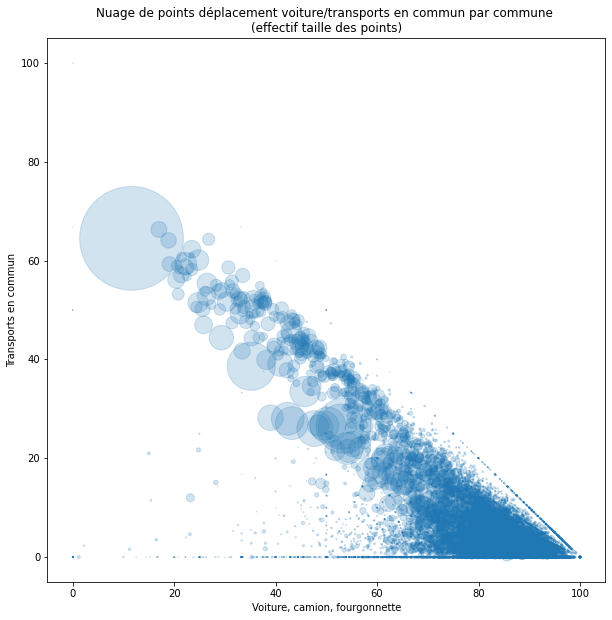

In [56]:
# Constuction du tableau croisé pondéré
t,a,p = pyshs.tableau_croise(data_ind,"COMMUNE","TRANS_reco","IPONDI",debug=True)

# Graphique avec les pourcentages par commune voiture vs. transports en commun
p.drop("All").plot(kind="scatter",
                   x="Voiture, camion, fourgonnette",
                   y="Transports en commun",
                   figsize=(10,10),
                   s=a["All"].drop("All")/100,
                   alpha=0.2)
plt.title("Nuage de points déplacement voiture/transports en commun par commune \n(effectif taille des points)")
plt.show()

On voudrait analyser un peu plus cette dimension spaciale. Avant cela, il nous faut une variable supplémentaire.

### 2.2 Ajout d'une nouvelle dimension : la distance parcourue

Pour cela, on doit passer par les données de localisation de la carte car les données initiales ne contiennent pas de données géographiques.

Il faut donc apparier l'information de la commune de résidence et de travail à une coordonnée géographique. C'est une approximation : nous n'avons pas l'adresse exacte mais uniquement la commune.

- DCLT Département, commune et arrondissement municipal (Paris,Lyon,Marseille) du lieu de travail
- COMMUNE Département et commune du lieu de résidence

Il y a deux manières de calculer des distances :

- en distance à vol d'oiseau de centre de commune à commune
- par temps de route utilisant un routeur de parcours

La première est faisable sans service extérieur; la seconde nécessite un service de routage, nous montrons un exemple de comment faire ce type de traitement mais la généralisation nécessiterait une table de parcours trop massive pour être réalisée dans le cadre de ce Notebook réexécutable.

Nous utilisons maintenant le tableau chargé dans la variable `carte` qui est un tableau `Geopandas`, incluant une dimension spatiale, et permettant de faire certains calculs spécifiques.

Vérifier le type de projection

In [153]:
carte["geometry"].crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Les données sont des projections GPS ou `EPSG:4326`

Il est possible de calculer le centre de charge zone géographique (commune).

In [23]:
# Calcul des centres
carte["centres"] = carte["geometry"].centroid

# Variables spécifiques de coordonnées
coordonnees = carte.set_index("insee")["centres"]

/var/folders/0b/gc4xjfv921z5v__d9vs4ysp40000gn/T/ipykernel_12032/962290003.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  carte["centres"] = carte["geometry"].centroid


In [24]:
coordonnees.head()

insee
2B222    POINT (9.33815 42.37429)
2B137    POINT (9.23536 42.37887)
2B051    POINT (9.30211 42.36875)
2B106    POINT (9.26661 42.37556)
2B185    POINT (9.33385 42.64177)
Name: centres, dtype: geometry

Pour chaque donnée, on ajoute les coordoonnées associées à la ville de départ, et à la ville d'arrivée

In [59]:
data_ind = data_ind.join(coordonnees,on="COMMUNE",rsuffix="_residence")
data_ind = data_ind.join(coordonnees,on="DCLT",rsuffix="_travail")

Il est maintenant possible de calculer la distance linéaire entre le centre de la ville de départ et celle d'arrivée, en respectant la projection utilisée.

In [61]:
# Définition d'une fonction qui fait le calcul pour deux points
def distance(point1,point2):
    if pd.isnull(point1) or pd.isnull(point2):
        return None
    if point1==point2:
        return 0
    return geodesic((point1.y,point1.x), (point2.y,point2.x)).kilometers

# Application à l'ensemble des données
# Attention, environ 30 min de calcul pour passer l'ensemble du corpus
# %time data_ind.sample(10000).apply(lambda x: distance(x["centres"],x["centres_travail"]),axis=1)
%time data_ind["distance_travail"] = data_ind.apply(lambda x: distance(x["centres"],x["centres_travail"]),axis=1)

# Sauvegarde intermédiaire du jeu de données
pickle.dump(data_ind,open("../data/data_ind.pkl","wb"))

CPU times: user 29min 22s, sys: 16.3 s, total: 29min 38s
Wall time: 30min 23s


Si besoin, chargement du jeu de donnée intermédiaire :

In [2]:
data_ind = pickle.load(open("../data/data_ind.pkl","rb"))

Nous avons donc une nouvelle variable qu'il est possible d'analyser : la distance parcourue

In [4]:
data_ind["distance_travail"].describe()

count    6.786223e+06
mean     1.555643e+01
std      1.280589e+02
min      0.000000e+00
25%      0.000000e+00
50%      5.366637e+00
75%      1.332116e+01
max      1.343128e+04
Name: distance_travail, dtype: float64

En traçant sa distribution rapidement

<AxesSubplot:>

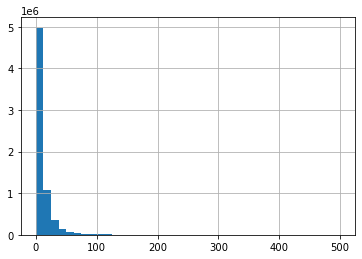

In [3]:
data_ind[data_ind["distance_travail"]<500]["distance_travail"].hist(bins=40)

Il existe d'autres méthodes que la distance linéaire

### 2.3 Interroger un service de routage pour la distance parcourue

Plutôt que de calculer la distance directe entre deux communes, il peut être intéressant d'avoir une information sur le temps de route moyen en voiture, qui reste le principal moyen de déplacement.

Le projet OSRM *Open Source Routing Machine* http://project-osrm.org/ propose une API.

Un des services permet de récupérer une table de temps entre des points. On va le faire pour les déplacements d'un département afin de limiter la charge. Pour cela il faut créer une liste des points dont on veut les relations. On va le faire pour le département des Bouches du Rhônes.

In [141]:
points = dict(carte[carte["insee"].apply(lambda x : True if x[0:2]=="13" else False)].set_index("nom")["centres"])
points_str = {i:f"{points[i].x},{points[i].y}" for i in points}
print(len(points))


119


Un peu trop de points, on va le faire sur un sous-ensemble des 10 premiers points, pour ne pas surcharger le service.

In [137]:
# Construction de la requête à partir de la documentation
req = "http://router.project-osrm.org/table/v1/driving/"+(";".join([points_str[i] for i in points_str][0:10]))

# Exécution de la requête avec Requests
rep = requests.get(req)

# Récupération des données en JSON
rep_json = rep.json()

Mise en forme des données récupérées sous la forme d'une matrice.

In [139]:
noms = [i for i in points][0:10]
tableau_temps = pd.DataFrame(rep_json["durations"],columns = noms, index= noms)
tableau_temps

,Simiane-Collongue,Aix-en-Provence,Le Puy-Sainte-Réparade,Marseille,Mollégès,Verquières,Saint-Andiol,Noves,Cabannes,Eygalières
Simiane-Collongue,0.0,1466.9,2525.5,1871.1,3778.3,3942.8,3636.8,4003.0,3582.1,3939.3
Aix-en-Provence,1494.1,0.0,1587.4,2192.9,2705.7,2870.2,2564.2,2930.4,2509.5,2866.7
Le Puy-Sainte-Réparade,2513.5,1554.3,0.0,3212.3,3477.2,3654.9,3348.9,3715.1,3294.2,3577.5
Marseille,1832.4,2144.7,3203.3,0.0,3997.0,4161.5,3855.5,4221.7,3800.8,4158.0
Mollégès,3746.9,2750.2,3486.0,3991.4,0.0,505.3,363.6,886.6,732.7,472.7
Verquières,3880.7,2884.0,3619.8,4125.2,492.3,0.0,312.0,475.4,551.8,937.2
Saint-Andiol,3601.5,2604.8,3340.6,3846.0,365.6,322.4,0.0,703.7,456.3,810.5
Noves,3996.1,2999.4,3735.2,4240.6,881.7,471.8,701.4,0.0,760.7,1326.6
Cabannes,3550.7,2554.0,3289.8,3795.2,735.7,551.7,465.8,766.5,0.0,1143.4
Eygalières,3901.0,2904.3,3590.0,4145.5,473.3,945.3,803.6,1326.6,1142.1,0.0


Il est alors possible de calculer la vitesse moyenne entre les villes (La réponse temporelle est en seconde).

In [ ]:
# On reconstruit un tableau en divisant la distance par le temps
tableau_distance = []
for i in noms:
    ligne = []
    for j in noms:
        ligne.append(geodesic((points[i].y,points[i].x), (points[j].y,points[j].x)).kilometers)
    tableau_distance.append(ligne)
tableau_distance = pd.DataFrame(tableau_distance,columns=noms,index=noms)
tableau_distance

Il est possible d'avoir plutôt la vitesse en km/h

In [169]:
tableau_distance/(tableau_temps / (60*60))

,Simiane-Collongue,Aix-en-Provence,Le Puy-Sainte-Réparade,Marseille,Mollégès,Verquières,Saint-Andiol,Noves,Cabannes,Eygalières
Simiane-Collongue,NaN,34.846621,38.022617,25.623463,56.096701,57.766595,60.331761,59.370032,63.255815,50.506464
Aix-en-Provence,34.212240,NaN,30.050509,44.535112,62.493795,64.250504,68.448761,66.228022,72.333151,55.139210
Le Puy-Sainte-Réparade,38.204146,30.690457,NaN,44.761748,44.551071,46.093207,47.465327,47.705671,49.253369,41.427263
Marseille,26.164626,45.535995,44.887510,NaN,61.656141,63.062312,66.087557,64.523788,69.216384,55.764148
Mollégès,56.566806,61.482605,44.438607,61.742646,NaN,31.654789,27.943285,29.280989,29.292047,36.443310
Verquières,58.690992,63.943064,46.540158,63.617234,32.490687,NaN,30.687982,20.965793,25.055501,34.201383
Saint-Andiol,60.923101,67.381877,47.583258,66.250800,27.790423,29.698047,NaN,26.432086,24.958572,33.769573
Noves,59.472546,64.704473,47.448955,64.236210,29.443717,21.125769,26.518761,NaN,22.333349,31.417841
Cabannes,63.815207,71.072844,49.319244,69.318516,29.172601,25.060043,24.449541,22.164356,NaN,33.720099
Eygalières,51.002336,54.425360,41.283017,55.932295,36.397111,33.908321,34.059530,31.417841,33.758481,NaN


Il y a des variations importantes, la distance linéaire n'est peut être pas la meilleure manière de traiter l'information

## 3. Représenter les mobilités

L'objectif est de représenter les mobilités. Deux stratégies peuvent être envisagées : à l'échelle de l'individu, ou à l'échelle de la commune. Une représentation à l'échelle de la commune permet de faire une cartographie. Nous allons donc agréger les informations individuelles à l'échelle de la commune.

Ce qui revient à calculer la distance moyenne et médiane parcourue par les habitants sur la commune

In [171]:
distance_commune_moyenne = data_ind.groupby("COMMUNE")["distance_travail"].mean()
distance_commune_mediane = data_ind.groupby("COMMUNE")["distance_travail"].median()

A partir de cela, il est possible de tracer une carte à l'échelle de la commune. Le choix est fait de se concentrer sur la métropole en filtrant les DOM-TOM (nous laissons en exercice l'analyse des DOMTOM, suivant la même méthode).

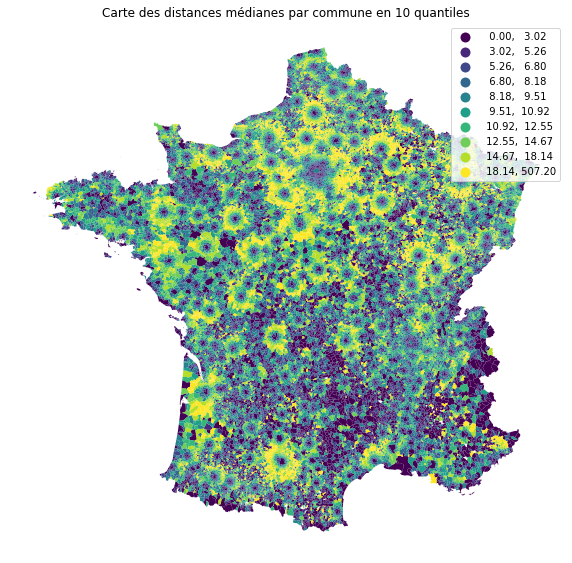

In [172]:
# Construction d'un filtre
filtre_metropole = carte["insee"].apply(lambda x : False if x[0:2] in ["97","98"] or "A" in x or "B" in x else True)

# Ajout de la colonne distance au tableau géographique
carte_distances = carte.join(distance_commune_mediane, on="insee")[filtre_metropole]

# Tracer la carte, avec des déciles pour la distance
carte_distances.plot(column='distance_travail',legend=True,
                     scheme="quantiles",k=10,figsize=(10,10))

# Mise en forme de la carte
plt.title("Carte des distances médianes par commune en 10 quantiles")
plt.axis('off')
plt.savefig("../results/carte_distance_mediane_commune.png", bbox_inches='tight',dpi=300)

Cette carte permet de voir apparaitre des régions différenciées de déplacement, largement structurée par les poles attracteurs urbains.

Il est aussi possible de zoomer sur certains départements. La limite est alors la granularité des communes.

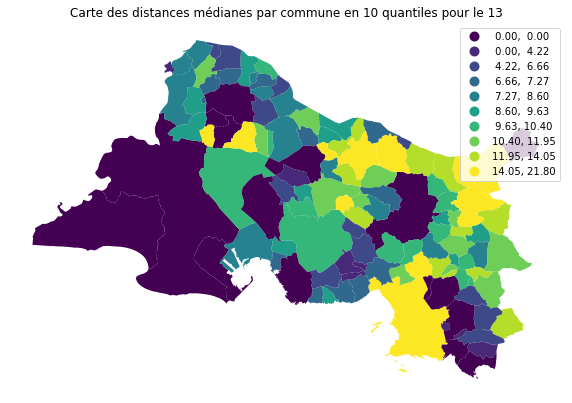

In [179]:
# Filtre
filtre13 = carte["insee"].apply(lambda x : True if x[0:2]=="13" else False)

# Sélection de la carte
carte_distances = carte.join(distance_commune_mediane, on="insee")[filtre13]

# Visualisation
carte_distances.plot(column='distance_travail',legend=True,
                     scheme="quantiles",k=10,figsize=(10,10))
plt.title("Carte des distances médianes par commune en 10 quantiles pour le 13")
plt.axis('off')
plt.show()

Nous vous laissons explorer d'autres zones...

## 4.Étudier les profils des communes

Les comportements de déplacements sont différents suivant les communes. Il est possible de se demander quelle est la part de cette pratique qui dépendant de la commune et quelle part qui dépend des habitants.

Pour cela, nous allons aussi utiliser les données INSEE à l'échelle de la commune, plus adaptée à ce niveau d'analyse. Nous allons essayer de construire des classifications.

### 4.1 Construire des catégories

Nous pouvons décrire les communes par une diversité de caractéristiques populationnelles (profil de la population, etc.). Cependant le nombre de communes est improtant et nous voudrions réduire les dimensions. Une première stratégie est d'utiliser une analyse factorielle puis une classification en K-Means. Une deuxième stratégie est d'utiliser une méthode non linéaire de classification comme UMAP.

#### 4.1.1 Préparation des données

Nous utilisons uniquement une partie des dimensions correspondant au recensement de 2019 (préfix P18_), nous retirons les questions spécifiques aux mobilités qui sont incorporées pour construire une caractérisation uniquement sur le profil des villes et nous normalisons en proportion du nombre d'habitant toutes les variables données en valeurs absolues.

In [263]:
# Enlever les colonnes qui ont trop de valeurs nulles
var_nulles = pd.isnull(data_com).sum()>10000
var_nulles = var_nulles[var_nulles].index

# Toutes les variables du sondage de 2019
var_19_communes = list(meta_com[meta_com["COD_VAR"].str.contains("P19_")]["COD_VAR"])

# Enlever les items mobilités et portant sur la possession de voiture
var_19_communes = [i for i in var_19_communes if \
                   not "ACTOCC15P" in i\
                   and not "P19_RP_VOIT" in i\
                   and not i in var_nulles
                  ]

# Tableau de description des communes
description_communes = data_com.set_index("CODGEO")[var_19_communes]

In [ ]:
# Ajout de la superficie aux données à partir des informations de la carte
description_communes = description_communes.join(carte.set_index("insee")["surf_ha"])

In [386]:
# Normalisation par la population du tableau de données pour avoir des densités par habitants
description_communes = pd.concat([description_communes.apply(lambda l : l[var_19_communes[1:]]/l["P19_POP"] if pd.notnull(l["P19_POP"]) else None,axis=1),
                                    description_communes['P19_POP']],axis=1)

#Enlever les lignes ayant des valeurs nulles
description_communes = description_communes.dropna()

description_communes.shape


(34864, 338)

Il serait possible d'explorer les différentes formes de normalisation pour voir si cela a des conséquences sur les résultats ultérieurs (ce traitement n'est pas réalisé dans ce Notebook).

#### 4.1.2 ACP et K-Means

Projeter le tableau dans un espace de dimension inférieure avec une analyse en composante principale.

In [41]:
# Définition de la projection et projection
projection = prince.PCA(n_components=7)
projection = projection.fit(description_communes)

# Tableau projeté
Xt = projection.row_coordinates(description_communes)

Distribution du poids des axes

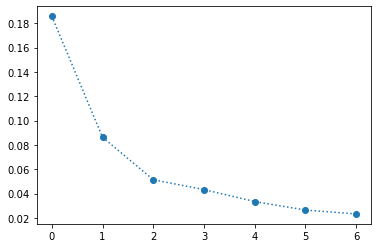

In [42]:
plt.plot(projection.explained_inertia_,"o:")

Il est intéressant de regarder les corrélations entre les variables pour leur donner du sens. Dans ce cas, on va construire le cercle de corrélation "lisible" en sélectionnant uniquement les variables dont la corrélation avec les axes est supérieur à un certain seuil.

In [62]:
correlations = projection.column_correlations(description_communes).sort_values(0)
correlations.head()

,0,1,2,3,4,5,6
P19_POP2554,-0.836240,-0.114227,0.132406,-0.111180,0.292675,0.006885,-0.030225
P19_ACT2554,-0.834295,-0.235730,0.164388,-0.137258,0.237302,0.036732,-0.096818
P19_ACTOCC2554,-0.810704,-0.342267,0.190627,-0.133075,0.119844,0.023597,-0.231733
P19_SAL15P,-0.809671,-0.174825,0.287491,0.087629,-0.073496,0.336047,-0.167373
P19_POP0014,-0.801257,-0.090111,-0.452216,-0.151352,0.097199,-0.023339,0.043232


Construction d'une figure : en effet, le cercle de corrélation n'est pas donnée par les bibliothèques existantes; il est donc possible de le construire comme on le souhaite.

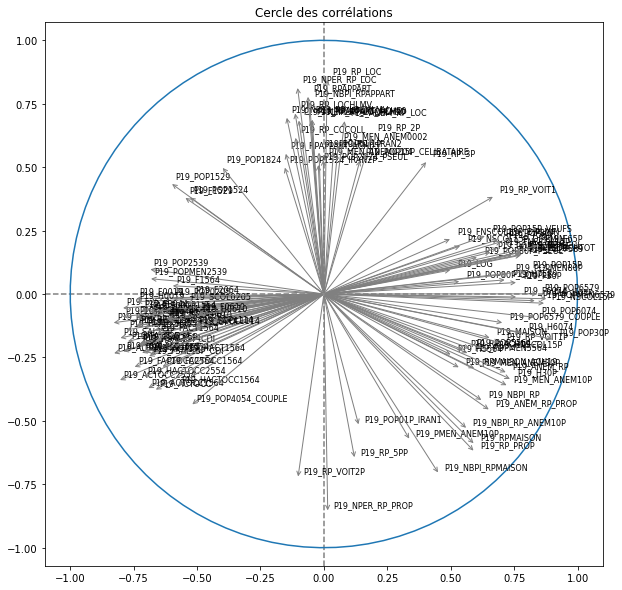

In [63]:
# seuil de corrélation limite
seuil_corr = 0.5

# Définir une figure
fig,ax = plt.subplots(figsize=(10,10))

# Parcourir chaque variable
for i,j in correlations.iterrows():
    
    # Si le seuil est dépassé pour l'une des dimensions
    if abs(j[0]) >= seuil_corr or abs(j[1]) >= seuil_corr :
        
        # Ajouter la flêche et l'annotation correspondante
        ax.annotate("",xy=(j[0],j[1]), xytext = (0,0), 
                    arrowprops = {"arrowstyle":"->","color":"gray"})
        ax.annotate(i,(j[0]+0.02,j[1]+0.02), size=8)
    
# Mettre en forme la figure avec le cercle
ax.set_title("Cercle des corrélations")
ax.axhline(y=0, color = "grey", linestyle = "--")
ax.axvline(x=0, color = "grey", linestyle = "--")
an = np.linspace(0,2 * np.pi, 100)
plt.plot(np.cos(an),np.sin(an))
plt.axis("equal")
plt.show()

In [64]:
variable("P19_RP_LOC",meta_com)

'Rés princ occupées Locataires en 2019 (princ)'

On renomme le premier pour le conserver par la suite.

In [325]:
Xt = Xt.rename(columns = {0:"Projection"})
carte = carte.join(Xt["Projection"], on="insee")

Une pratique courante pour construire un indicateur unidimensionnel est de conserver le premier axe d'une ACP sur un grand jeu de données. Dans notre cas, le premier axe de l'ACP représente près de 20% de la variance.

In [ ]:
carte = carte.join(description_communes["categorie"].apply(str), on="insee")

Il est aussi possible d'utiliser l'ensemble des dimensions pour ensuite procéder à une classification. Pour cela, nous calculons une clusterisation avec k-means.

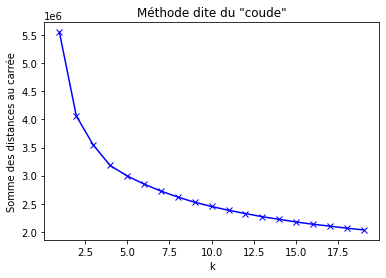

In [268]:
inerties = []
K = range(1, 20)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(Xt)
    inerties.append(km.inertia_)

plt.plot(K, inerties, "bx-")
plt.xlabel("k")
plt.ylabel("Somme des distances au carrée")
plt.title('Méthode dite du "coude"')
plt.show()

On va garder 5 clusters

In [281]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5, random_state=0).fit(Xt)
data["clusters_kmeans"] = kmeans.labels_

In [282]:
description_communes["categorie"] = kmeans.labels_

In [290]:
carte = carte.join(description_communes["categorie"].apply(str), on="insee")

Représentation des deux méthodes de classification

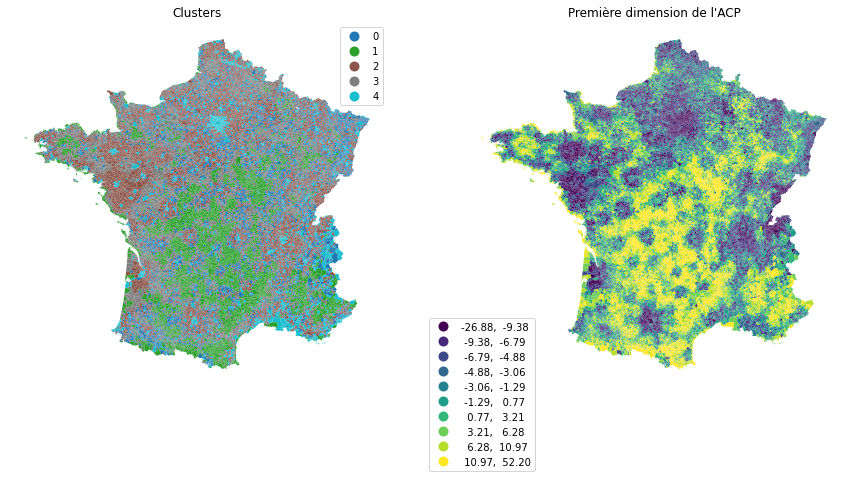

In [328]:
fig, ax = plt.subplots(1,2,figsize=(15,10))

# Première carte
carte[filtre_metropole].plot(column='categorie',legend=True,
                     k=10,ax=ax[0])

# Deuxième carte
carte[filtre_metropole].plot(column='Projection',legend=True,
                             ax=ax[1],scheme="quantiles",k=10)

ax[0].set_title("Clusters")
ax[0].axis('off')

ax[1].set_title("Première dimension de l'ACP")
ax[1].axis('off')

# Déplacement de la légende
leg = ax[1].get_legend()
leg.set_bbox_to_anchor((0., 0., 0.2, 0.2))

Sans surprise, il y a une correspondance générale entre ces deux indicateurs.

Cette carte prend en compte toutes les dimensions : sociales, mais aussi mobilités.

## 5. Regrouper les communes par proximité de déplacement

Comme nous avons des données sur les déplacements professionnels, il est aussi possible de regrouper les communes par proximité fonctionnelle entre résidence/travail.

Pour cela, nous allons utiliser une stratégie en termes d'analyse de réseaux.

### 5.1 Construire le réseau des trajets

L'idée est de construire le réseau des liens entre la ville de résidence et la ville de travail. Les noeuds sont donc des villes ; le lien est l'existence d'un trajet professionnel. Chaque ville est définie par le nombre d'actifs.

On va donc faire un réseau en itérant sur le tableau et en augmentant de 1 la pondération de la ville de résidence et de 1 le lien entre les deux villes concernées. Pour des raisons de simplicité, nous utilisons un réseau non-orienté (il est évidemment possible de refaire cette analyse avec un réseau orienté dans la mesure où les flux sont orientés)

Pour cela, nous utilisons la bibliothèque `networkx`. La construction du réseau prend un peu de temps car on itère sur les millions de lignes.

In [91]:
noms_villes = carte.set_index("insee")["nom"]


In [95]:
data_ind["DCLT"].iloc[1]

'01001'

In [206]:
# création d'un réseau vide
reseau = nx.Graph()

# boucle sur les données
for i,ligne in data_ind[0:100000].iterrows():
    

    commune_residence = ligne["COMMUNE"]
    commune_travail = ligne["DCLT"]        
    
    # Si la commune n'est pas présente, la créer, sinon ajouter
    if not commune_residence in reseau.nodes:
        reseau.add_node(commune_residence,label=commune_residence,poids=1)
    else:
        reseau.nodes[commune_residence]["poids"] += 1
    
    # Pareil pour la commune d'arrivée sans incrémenter
    if not commune_travail in reseau.nodes:
        reseau.add_node(commune_travail,label=commune_travail,poids=1)
        
    # Si le lien n'existe pas, le créer, sinon incrémenter
    if not reseau.has_edge(ligne["COMMUNE"],ligne["DCLT"]):
        reseau.add_edge(ligne["COMMUNE"],ligne["DCLT"],poids=1)
    else:
        reseau[ligne["COMMUNE"]][ligne["DCLT"]]["poids"]+=1

On a donc un réseau qui a les propriétés suivantes :

In [207]:
print("Nombre de noeuds : ",len(reseau.nodes))
print("Nombre de liens : ", len(reseau.edges))

Nombre de noeuds :  35355
Nombre de liens :  782844


Une fois le réseau construit, il est souhaitable de le sauvegarder (pour le charger, mais aussi pour éventuellement l'ouvrir avec un logiciel tiers comme Gephi)

In [208]:
nx.write_graphml(reseau, "../data/reseau_circulation_pro_villes.graphml")

### 5.2 Visualiser un réseau

La visualisatio de réseau demande des ressources. Pour cette raison il est difficile de visualisation l'ensemble du réseau et il est préférable de visualiser des éléments précis, par exemple l'égo-graph centré sur une ville à un certain diamètre (1, ou 2).

In [194]:
sous_reseau = nx.ego_graph(reseau,'69381',1)

Utilisation de bibliothèque `Networkx` pour la visualisation

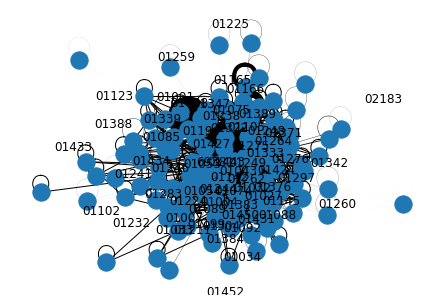

In [195]:
position = nx.draw_spring(sous_reseau)
poids = [sous_reseau[u][v]['poids']/100 for u,v in sous_reseau.edges()]
nx.draw_networkx_labels(sous_reseau, pos=nx.spring_layout(sous_reseau))
nx.draw(sous_reseau, position, width=poids)
plt.show()

Utilisation de la bibliothèque `Pyvis` pour la visualisation interactive.

In [196]:
from pyvis import network

visu = network.Network(notebook=True)
visu.from_nx(sous_reseau)
visu.show("reseau.html")

### 5.3 Clusters dans un réseau

Il existe différentes stratégies spécifiques pour trouver des clusters dans un réseau tenant compte de la structure de ce réseau. Un des algorithmes les plus utilisés est la détection de modularité Louvain https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.community.louvain.louvain_communities.html

In [212]:
import networkx.algorithms.community as nx_comm

# Identification des clusters
seuil = 1
clusters = nx_comm.louvain_communities(reseau, seed=123,weight="poids",threshold=seuil)
print(f"Il y a {len(clusters)} clusters")

Il y a 484 clusters


### 5.4 Carte des zones

Remettons les données en forme pour les mettre sur une carte

In [216]:
attribution = []
for i in range(0,len(clusters)):
    for j in clusters[i]:
        attribution.append([i,j])
attribution = pd.DataFrame(attribution,columns = ["cluster","insee"]).set_index('insee')
attribution["cluster"] = attribution["cluster"]#.apply(str)

Et affichage des zones détectées

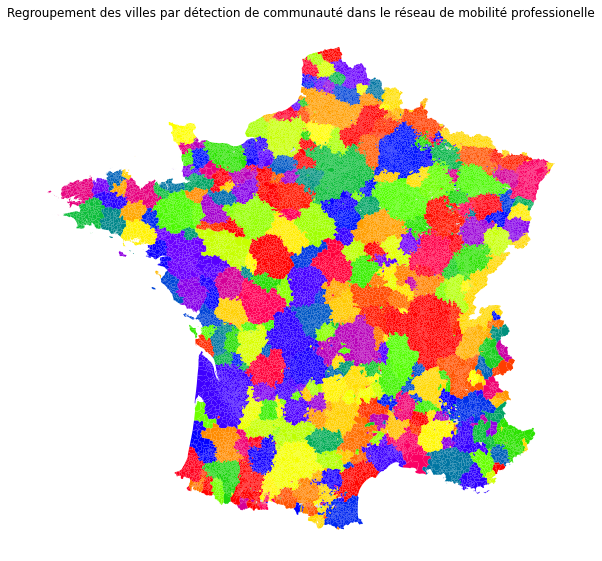

In [218]:
filtre_metropole = carte["insee"].apply(lambda x : False if x[0:2] in ["97","98"] or "A" in x or "B" in x else True)

carte_clusters = carte.join(attribution, on="insee")[filtre_metropole]

carte_clusters.plot(column='cluster',legend=False,
                    figsize=(10,10),
                   missing_kwds= dict(color = "lightgrey",),cmap="prism")

plt.title("Regroupement des villes par détection de communauté dans le réseau de mobilité professionelle")
plt.axis('off')
plt.show()

## 6. Utiliser la catégorie spatiale dans un modèle

Pour la dernière étape dans ce Notebook, nous voudrions prédire la proportion de possesseurs de voiture dans une ville. Certainement, cela sera en lien avec la proportion d'actifs. Mais il est possible aussi que ce soit en lien avec la situation spatiale de la ville. Pour cela, un modèle spatial pourrait être pertinent.

La variable d'intérêt est `P19_RP_VOIT1P`. Nous allons la normaliser par rapport au nombre d'habitants de la commune.

### 6.1 Analyse descriptive

In [332]:
variable("P19_RP_VOIT1P",meta_com)

'Ménages au moins une voiture en 2019 (princ)'

Nombre de valeurs nulles 39


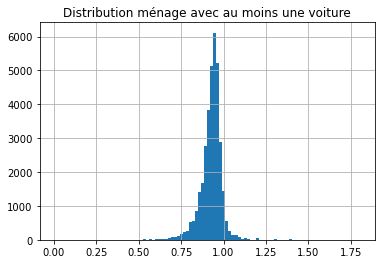

In [368]:
data_com["prop_menage_voiture"] = data_com[["P19_RP_VOIT1P","C19_MEN"]].apply(lambda x : None if pd.isnull(x["P19_RP_VOIT1P"])\
                                                                            or pd.isnull(x["C19_MEN"])\
                                                                            or x["C19_MEN"]==0\
                                                                            else x["P19_RP_VOIT1P"]/x["C19_MEN"],
                                                                       axis=1)
print("Nombre de valeurs nulles", pd.isnull(data_com["prop_menage_voiture"]).sum())
data_com["prop_menage_voiture"].hist(bins=100)
plt.title("Distribution ménage avec au moins une voiture")
plt.show()

Il semble y avoir des erreurs dans les données, car on a une proportion suppérieure à 1. Une investigation serait nécessaire pour comprendre cette différence. 

Représentons à l'échelle nationale cette distribution.

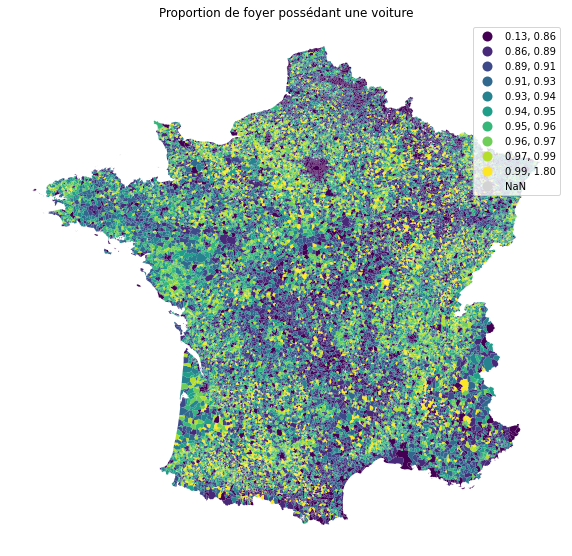

In [371]:
carte[filtre_metropole].join(data_com.set_index("CODGEO")["prop_menage_voiture"],on="insee").plot(column='prop_menage_voiture',
                    figsize=(10,10),
                    legend=True,
                    missing_kwds= dict(color = "lightgrey",),
                    cmap="viridis",scheme="quantiles",k=10)
plt.title("Proportion de foyer possédant une voiture")
plt.axis('off')
plt.show()

L'idée serait maintenant de modéliser au mieux cette proportion de ménage ayant une voiture. On peut utiliser un modèle linéaire pour modéliser la proportion en fonction de tous les autres paramètres.

Pour une logique plus prédictive que descriptive, on peut utiliser toutes les variables en partie corrélées. Donc on sélectionne les variables corrélées au-dessus d'un seuil, et ont fait un modèle.

### 6.2 Modèle linéaire multivarié

In [388]:
tableau = description_communes.join(data_com.set_index("CODGEO")["prop_menage_voiture"])

In [403]:
variable("P19_RP_LOC",meta_com)

'Rés princ occupées Locataires en 2019 (princ)'

In [413]:
var_corr = []
seuil = 0.3
for i in var_19_communes:
    cor = tableau[[i,"prop_menage_voiture"]].corr().iloc[1,0]
    if abs(cor)>seuil:
        var_corr.append([i, variable(i,meta_com),cor])
        
pd.DataFrame(var_corr,columns=["variable","descriptif","corrélation"])\
            .sort_values("corrélation")\
            .set_index("variable")

,descriptif,corrélation
variable,,
P19_RP_LOC,Rés princ occupées Locataires en 2019 (princ),-0.492193
P19_ANEM_RP_LOC,Anc tot Emméngt Rés princ occ par Locataires (...,-0.482886
P19_RPAPPART,Rés princ type appartement en 2019 (princ),-0.478114
P19_ANEM_RP_LOCHLMV,Anc tot Emméngt Rés princ HLM louées vides (an...,-0.467491
P19_RPAPPART_ACH70,Rés princ Type appart 1946 à 1970 en 2019 (princ),-0.465378
P19_NBPI_RPAPPART,Pièces rés princ type appartement en 2019 (princ),-0.462217
P19_NPER_RP_LOC,Pers Rés princ occupées Locataires en 2019 (pr...,-0.453624
P19_RP_LOCHLMV,Rés princ HLM louée vide en 2019 (princ),-0.452505
P19_NPER_RP_LOCHLMV,Pers Rés princ HLM louées vides en 2019 (princ),-0.438882


On peut faire un modèle. Attention, il y a des valeurs nulles; dans notre cas, nous allons simplement les enlever. Par rapport à `scikit-learn`, `statsmodels` donne des résumés plus interprétables.

In [426]:
pd.isna(Y).sum()

6

In [435]:
from statsmodels.api import OLS

# filtre des valeurs non nulles
na = pd.notna(tableau["prop_menage_voiture"])

# construction des tableaux pour le modèle
Y = tableau[na]["prop_menage_voiture"]
X = tableau[na][[i[0] for i in var_corr]]

# Il faut ajouter une constante pour avoir le modèle
Xm = sm.add_constant(X)

# Construction du modèle et calcul du score
reg = OLS(Y,Xm).fit()
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     prop_menage_voiture   R-squared:                       0.454
Model:                             OLS   Adj. R-squared:                  0.453
Method:                  Least Squares   F-statistic:                     996.9
Date:                 Thu, 28 Jul 2022   Prob (F-statistic):               0.00
Time:                         12:13:43   Log-Likelihood:                 56249.
No. Observations:                34858   AIC:                        -1.124e+05
Df Residuals:                    34828   BIC:                        -1.122e+05
Df Model:                           29                                         
Covariance Type:             nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      1.0180      0.008    121.980      0.000       1.002       1.034
P19_POP80P_PSEUL          -0.6941      0.024    -28.999      0.000      -0.741      -0.647
P19_POP4054_COUPLE         0.0201      0.010      2.056      0.040       0.001       0.039
P19_POP15P_VEUFS          -0.1467      0.016     -9.316      0.000      -0.178      -0.116
P19_POP15P_CELIBATAIRE    -0.0965      0.008    -12.696      0.000      -0.111      -0.082
P19_RP_1P                 -0.6322      0.041    -15.549      0.000      -0.712      -0.552
P19_RP_2P                 -0.0987      0.022     -4.541      0.000      -0.141      -0.056
P19_RP_3P                  0.0238      0.014      1.691      0.091      -0.004       0.051
P19_RP_5PP                -0.0375      0.014     -2.733      0.006      -0.064      -0.011
P19_NBPI_RPMAISON          0.0241      0.003      8.872      0.000       0.019       0.029
P19_RPAPPART              -0.5089      0.044    -11.442      0.000      -0.596      -0.422
P19_NBPI_RPAPPART          0.2093      0.013     15.765      0.000       0.183       0.235
P19_RP_ACH70              -0.0911      0.010     -8.903      0.000      -0.111      -0.071
P19_RPAPPART_ACH19        -0.5857      0.027    -21.716      0.000      -0.639      -0.533
P19_RPAPPART_ACH45        -0.9749      0.047    -20.859      0.000      -1.066      -0.883
P19_RPAPPART_ACH70        -0.2440      0.033     -7.308      0.000      -0.309      -0.179
P19_RPAPPART_ACH90         0.1188      0.030      3.947      0.000       0.060       0.178
P19_RP_LOC                 0.2026      0.027      7.601      0.000       0.150       0.255
P19_RP_LOCHLMV             0.1585      0.065      2.445      0.014       0.031       0.286
P19_NPER_RP_PROP          -0.0617      0.008     -7.541      0.000      -0.078      -0.046
P19_NPER_RP_LOC           -0.1656      0.013    -13.047      0.000      -0.190      -0.141
P19_NPER_RP_LOCHLMV       -0.1061      0.026     -4.136      0.000      -0.156      -0.056
P19_ANEM_RP_LOC           -0.0058      0.001     -5.174      0.000      -0.008      -0.004
P19_ANEM_RP_LOCHLMV       -0.0263      0.003     -8.592      0.000      -0.032      -0.020
P19_RP_CCCOLL             -0.2369      0.018    -13.492      0.000      -0.271      -0.202
P19_NSCOL15P_DIPLMIN      -0.0067      0.011     -0.581      0.561      -0.029       0.016
P19_FNSCOL15P_DIPLMIN     -0.2425      0.020    -12.287      0.000      -0.281      -0.204
P19_ACTOCC1564             0.0323      0.037      0.880      0.379      -0.040       0.104
P19_ACTOCC2554            -0.0281      0.012     -2.337      0.019      -0.052      -0.005
P19_ACTOCC                 0.0422      0.035      1.192      0.233      -0.027       0.111
=====================================================================

Notre modèle a un $R^2$ de 0.45. Est-ce qu'on peut l'améliorer avec des variables spatiales ?

### 6.3 Régression spatiale

Pour faire une régression spatiale, il existe une bibliothèque dédiée `Pysal` (pour un tutorial plus long : https://geographicdata.science/book/notebooks/11_regression.html)

https://sustainability-gis.readthedocs.io/en/latest/lessons/L4/spatial_regression.html

In [442]:
from pysal.model import spreg
from pysal.lib import weights
from pysal.explore import esda

/Users/emilien/anaconda3/envs/geo_env/lib/python3.10/site-packages/pysal/explore/segregation/network/network.py:15: UserWarning: You need pandana and urbanaccess to work with segregation's network module
You can install them with  `pip install urbanaccess pandana` or `conda install -c udst pandana urbanaccess`
  warn(
/Users/emilien/anaconda3/envs/geo_env/lib/python3.10/site-packages/pysal/model/spvcm/abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


In [445]:
data = X.join(carte["geometry"])

In [1]:
w = weights.KNN.from_dataframe(data[0:1000], k=8)
w.transform = 'R'
w

NameError: name 'weights' is not defined

#### Logique de prédiction

## Aller plus loin

Il existe un sondage fin sur les mobilités, sur un échantillon plus petit de français 

- L'article descriptif : https://www.statistiques.developpement-durable.gouv.fr/comment-les-francais-se-deplacent-ils-en-2019-resultats-de-lenquete-mobilite-des-personnes
- Les données : https://www.statistiques.developpement-durable.gouv.fr/resultats-detailles-de-lenquete-mobilite-des-personnes-de-2019

### Développement

https://airtable.com/appUai6TBQqcwUVlB/pagjTCRAstQRDHrod?p63x5=recxMTMrm5WxgEX11

- animer le cercle de corrélation avec Bokeh / plotly pour avoir la possibilité de passer dessus et voir la question correspondante ?

Réflexion générale :

- des données à l'échelle individuelle de l'usage contiennent un nombre limité d'information, le plus important pour la réflexion ici étant 1/ Le mode de transport principal, 2/ la ville de résidence 3/ la ville de travail
- cela permet d'avoir un premier ensemble de traitements sur les déplacements. Cela permet de calculer un indicateur de flux pour les différentes villes et les représenter. La distance entre deux villes pourra être calculée avec Geopandas & le fond de carte et donc d'avoir une typologie (relative) des formes de déplacements des individus. 
- Est-il possible de faire du routage avec un service à distance ? Il existe le projet OSMR, open, avec une API et un wrapper Python : https://github.com/ustroetz/python-osrm Cela permet donc de calculer des distances en voiture. La question reste celle des coordonnées GPS des communes. Possible de je pense de les extraires avec Geopandas, sinon https://www.data.gouv.fr/en/datasets/listes-des-communes-geolocalisees-par-regions-departements-circonscriptions-nd/
- Une question qui se rajoute ensuite est "est-ce que l'usage de la voiture est structurel ou relève d'un choix individuel". Une première étape est de vérifier le profil des villes par agrégation des comportements. Ensuite un choix est de regarder la corrélation avec les particularités des communes. Cela peut être fait analytiquement en sélectionnant un nombre restreint de caractéristiques des villes (menu drop down ?).
- une étape mobilisant plus spécifiquement du ML serait de prédire si un utilisateur d'une ville particulière va utiliser sa voiture en fonction des caractéristiques A/ de sa ville de départ 2/ de sa ville d'arrivée, et identifier les meilleurs prédicteurs à cette situation. La particularité néanmoins est que nous avons beaucoup de variables quali ... 
  - mettre en place une stratégie de sélection